In [224]:
#!/usr/bin/env python3

import pandas as pd
import errno    
import os, sys
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20,5)

'''
Author: Enrico Ceccolini
'''

datadir = "/datasets/eurora_data/db1/"

# settings
interval_comment = "Andrea"
start_time = pd.to_datetime('2014-03-31')
end_time = pd.to_datetime('2014-05-01')
#interval_comment = "Alina"
#start_time = pd.to_datetime('2014-09-30')
#end_time = pd.to_datetime('2014-11-01')
suffix = "_1min_"  

infile_jobs = datadir + "CPUs/" + interval_comment + "/large_jobs_real_pow_" + interval_comment + ".csv"
interval_jobs = pd.read_csv(infile_jobs, index_col=0)
print("There are {} jobs in the {}'s interval".format(interval_jobs.shape[0], interval_comment))

There are 22459 jobs in the Andrea's interval


In [147]:
num_ran_alone = interval_jobs[interval_jobs['ran_alone'] == True].shape[0]
print("{} jobs ran alone".format(num_ran_alone))

13155 jobs ran alone


In [148]:
grouped_user_data = interval_jobs.groupby('user')['job_id_string'].nunique().reset_index(name='counts')
print("{} distinct users".format(grouped_user_data.shape[0]))

226 distinct users


In [149]:
grouped_user_data.sort_values('counts', ascending=False)

,user,counts
35,asaetti0@node129.eurora.cineca.it,6172
219,tbusatta@node129.eurora.cineca.it,1736
73,fpetracc@node129.eurora.cineca.it,1611
58,emarcucc@node129.eurora.cineca.it,1340
53,dmelazzi@node129.eurora.cineca.it,655
96,jfranz00@node129.eurora.cineca.it,569
71,fnegreir@node129.eurora.cineca.it,538
121,mmapelli@node129.eurora.cineca.it,495
143,nspalla1@node129.eurora.cineca.it,474
116,mdistefa@node129.eurora.cineca.it,442


In [150]:
print("{} users ran more than 100 jobs in the interval".format(grouped_user_data[grouped_user_data['counts'] >= 100].shape[0]))

37 users ran more than 100 jobs in the interval


In [151]:
grouped_jobs_data = interval_jobs.groupby('job_name')['job_id_string'].nunique().reset_index(name='counts')
print("{} distinct jobs names".format(grouped_jobs_data.shape[0]))

2639 distinct jobs names


In [152]:
grouped_jobs_data = interval_jobs.groupby(['user', 'job_name'])['job_id_string'].nunique().reset_index(name='counts')
grouped_jobs_data.sort_values('counts', ascending=False)

,user,job_name,counts
1351,fpetracc@node129.eurora.cineca.it,cosmomc_nMin20_,1576
1554,jfranz00@node129.eurora.cineca.it,g.job,511
3039,tbusatta@node129.eurora.cineca.it,scriptcineca_10,377
3043,tbusatta@node129.eurora.cineca.it,scriptcineca_50,313
3042,tbusatta@node129.eurora.cineca.it,scriptcineca_40,309
2756,spezzott@node129.eurora.cineca.it,DL_POLY_multi,268
1597,kkwapien@node129.eurora.cineca.it,job,268
3040,tbusatta@node129.eurora.cineca.it,scriptcineca_20,241
2001,nspalla1@node129.eurora.cineca.it,HPL-OFFLOAD,224
3041,tbusatta@node129.eurora.cineca.it,scriptcineca_30,203


In [153]:
print("{} users ran more than 100 time a job with the same name".format(grouped_jobs_data[grouped_jobs_data['counts'] >= 100].shape[0]))

24 users ran more than 100 time a job with the same name


In [263]:
job_id = "cosmomc_nMin20_"

specific_job = interval_jobs[interval_jobs['job_name'] == job_id]
print("there are {} entries".format(specific_job.shape[0]))
print("the std of the real pow is {}".format(specific_job['real_pow'].std()))

specific_job = interval_jobs[interval_jobs['job_name'] == job_id]
specific_job = specific_job[specific_job['real_pow_quality'] == 1.0]
print("there are {} entries".format(specific_job.shape[0]))
print("the std of the real pow is {}".format(specific_job['real_pow'].std()))

print("the mean value is {}".format(specific_job['real_pow'].mean()))

there are 1576 entries
the std of the real pow is 97.42601825543801
there are 1435 entries
the std of the real pow is 93.78438103982047
the mean value is 158.6926283440624


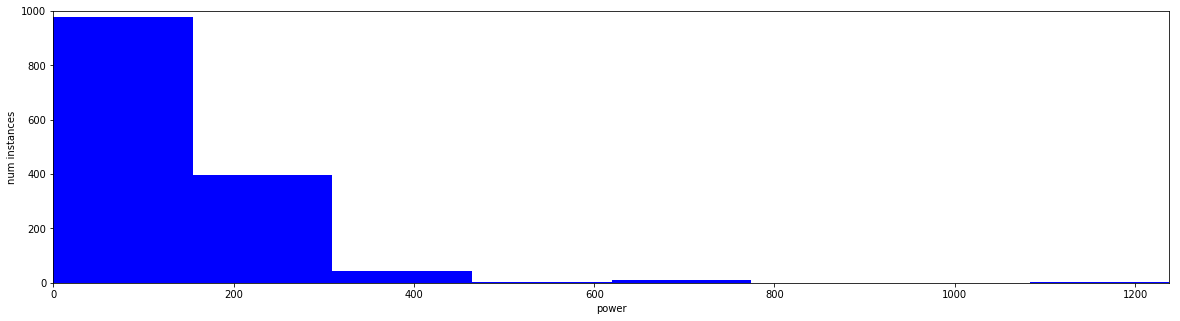

In [264]:
num_bins = 8
n, bins, patches = plt.hist(specific_job['real_pow'], num_bins, facecolor='blue', alpha=1)
plt.axis([int(specific_job['real_pow'].min()), int(specific_job['real_pow'].max()), 0, 1000])
plt.xlabel("power")
plt.ylabel("num instances")
plt.show()

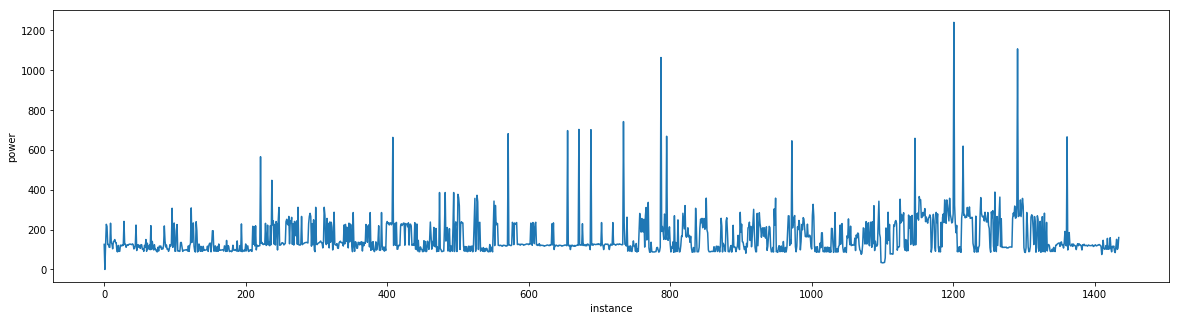

In [265]:
fig, ax = plt.subplots()
plt.plot(range(0, specific_job.shape[0]), specific_job['real_pow'])
plt.xlabel("instance")
plt.ylabel("power")
#plt.title(TITLE)
plt.show()

In [266]:
#specific_job.sort_values('real_pow', ascending=False)

In [267]:
job_id = "g.job"

specific_job = interval_jobs[interval_jobs['job_name'] == job_id]
print("there are {} entries".format(specific_job.shape[0]))
print("the std of the real pow is {}".format(specific_job['real_pow'].std()))

specific_job = interval_jobs[interval_jobs['job_name'] == job_id]
specific_job = specific_job.loc[(specific_job['real_pow_quality'] == 1.0) & (specific_job['ran_alone'] == True)]
print("there are {} entries".format(specific_job.shape[0]))
print("the std of the real pow is {}".format(specific_job['real_pow'].std()))

print("the mean value is {}".format(specific_job['real_pow'].mean()))

there are 511 entries
the std of the real pow is 35.73889247847243
there are 392 entries
the std of the real pow is 35.32378405267902
the mean value is 102.32586813706087


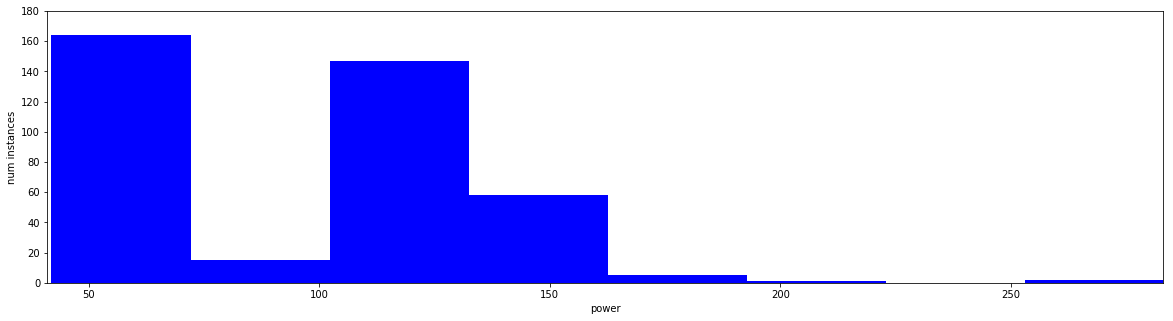

In [268]:
num_bins = 8
n, bins, patches = plt.hist(specific_job['real_pow'], num_bins, facecolor='blue', alpha=1)
plt.axis([int(specific_job['real_pow'].min()), int(specific_job['real_pow'].max()), 0, 180])
plt.xlabel("power")
plt.ylabel("num instances")
plt.show()

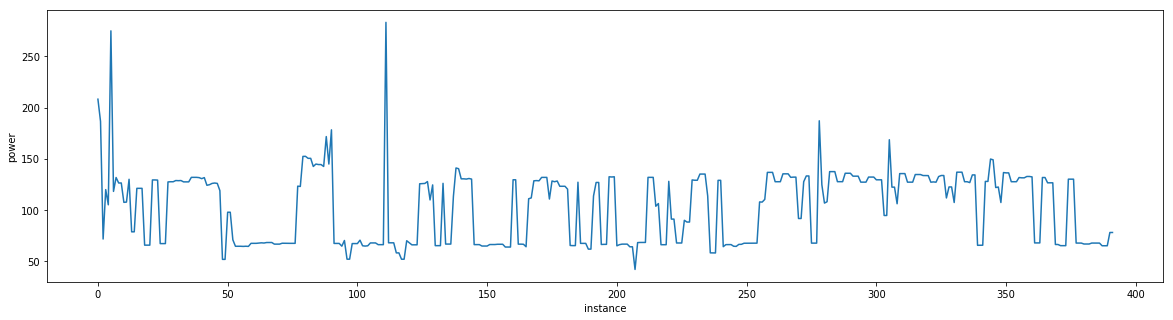

In [269]:
fig, ax = plt.subplots()
plt.plot(range(0, specific_job.shape[0]), specific_job['real_pow'])
plt.xlabel("instance")
plt.ylabel("power")
#plt.title(TITLE)
plt.show()

In [270]:
job_id = "scriptcineca_10"

specific_job = interval_jobs[interval_jobs['job_name'] == job_id]
print("there are {} entries".format(specific_job.shape[0]))
print("the std of the real pow is {}".format(specific_job['real_pow'].std()))

specific_job = interval_jobs[interval_jobs['job_name'] == job_id]
specific_job = specific_job.loc[(specific_job['real_pow_quality'] == 1.0) & (specific_job['ran_alone'] == True)]
print("there are {} entries".format(specific_job.shape[0]))
print("the std of the real pow is {}".format(specific_job['real_pow'].std()))

print("the mean value is {}".format(specific_job['real_pow'].mean()))

there are 377 entries
the std of the real pow is 41.95927545750325
there are 126 entries
the std of the real pow is 47.10318573005564
the mean value is 67.32232790608158


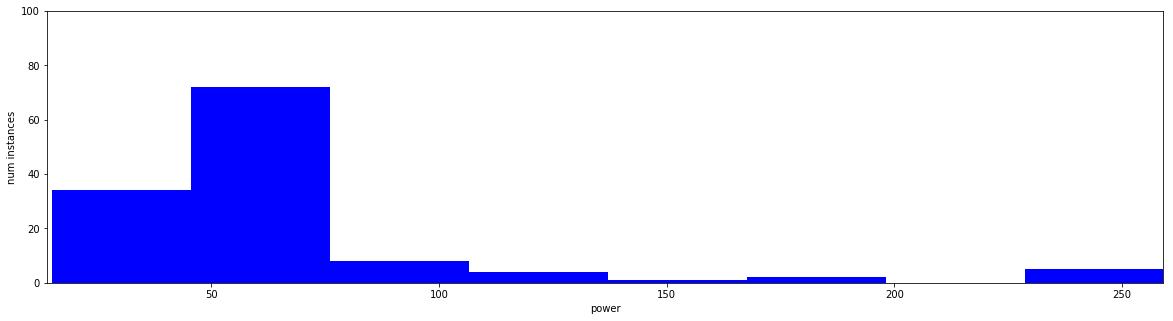

In [271]:
num_bins = 8
n, bins, patches = plt.hist(specific_job['real_pow'], num_bins, facecolor='blue', alpha=1)
plt.axis([int(specific_job['real_pow'].min()), int(specific_job['real_pow'].max()), 0, 100])
plt.xlabel("power")
plt.ylabel("num instances")
plt.show()

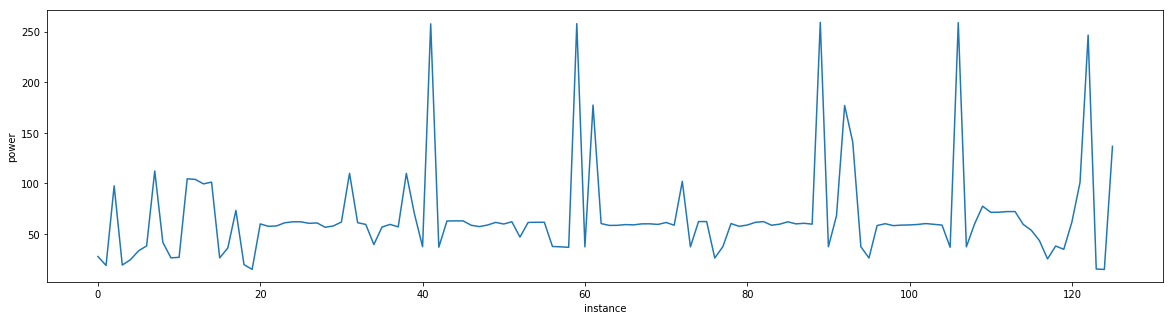

In [272]:
fig, ax = plt.subplots()
plt.plot(range(0, specific_job.shape[0]), specific_job['real_pow'])
plt.xlabel("instance")
plt.ylabel("power")
#plt.title(TITLE)
plt.show()

In [273]:
job_id = "scriptcineca_50"

specific_job = interval_jobs[interval_jobs['job_name'] == job_id]
print("there are {} entries".format(specific_job.shape[0]))
print("the std of the real pow is {}".format(specific_job['real_pow'].std()))

specific_job = interval_jobs[interval_jobs['job_name'] == job_id]
specific_job = specific_job.loc[(specific_job['real_pow_quality'] == 1.0) & (specific_job['ran_alone'] == True)]
print("there are {} entries".format(specific_job.shape[0]))
print("the std of the real pow is {}".format(specific_job['real_pow'].std()))

print("the mean value is {}".format(specific_job['real_pow'].mean()))

there are 313 entries
the std of the real pow is 33.03988559748996
there are 171 entries
the std of the real pow is 34.98677787065265
the mean value is 56.237789799212045


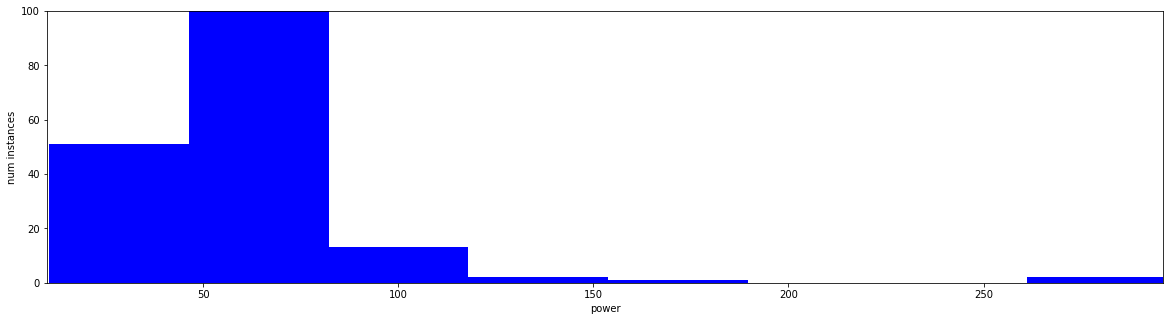

In [275]:
num_bins = 8
n, bins, patches = plt.hist(specific_job['real_pow'], num_bins, facecolor='blue', alpha=1)
plt.axis([int(specific_job['real_pow'].min()), int(specific_job['real_pow'].max()), 0, 10])
plt.xlabel("power")
plt.ylabel("num instances")
plt.show()

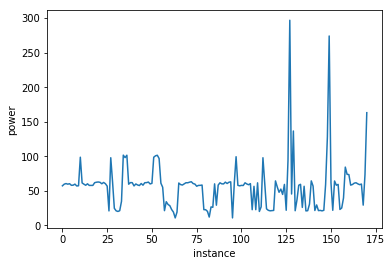

In [223]:
fig, ax = plt.subplots()
plt.plot(range(0, specific_job.shape[0]), specific_job['real_pow'])
plt.xlabel("instance")
plt.ylabel("power")
#plt.title(TITLE)
plt.show()

In [205]:
job_id = "scriptcineca_40"

specific_job = interval_jobs[interval_jobs['job_name'] == job_id]
print("there are {} entries".format(specific_job.shape[0]))
print("the std of the real pow is {}".format(specific_job['real_pow'].std()))

specific_job = interval_jobs[interval_jobs['job_name'] == job_id]
specific_job = specific_job.loc[(specific_job['real_pow_quality'] == 1.0) & (specific_job['ran_alone'] == True)]
print("there are {} entries".format(specific_job.shape[0]))
print("the std of the real pow is {}".format(specific_job['real_pow'].std()))

print("the mean value is {}".format(specific_job['real_pow'].mean()))

there are 309 entries
the std of the real pow is 35.5618271621107
there are 193 entries
the std of the real pow is 32.35648855453729
the mean value is 66.5045773730104


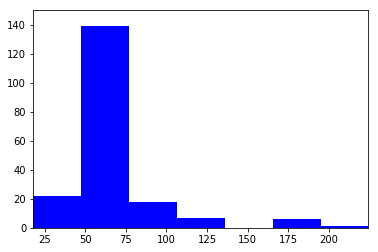

In [206]:
num_bins = 7
n, bins, patches = plt.hist(specific_job['real_pow'], num_bins, facecolor='blue', alpha=1)
plt.axis([int(specific_job['real_pow'].min()), int(specific_job['real_pow'].max()), 0, 150])
plt.show()

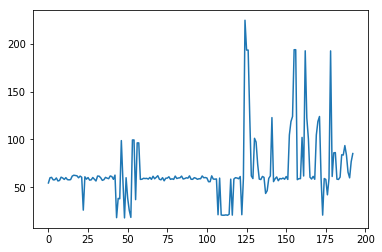

In [210]:
fig, ax = plt.subplots()
plt.plot(range(0, specific_job.shape[0]), specific_job['real_pow'])
#plt.xlabel(X_AXIS_NAME)
#plt.ylabel(Y_AXIS_NAME)
#plt.title(TITLE)
plt.show()


In [118]:
specific_job

,job_id_string,queue,start_time,run_start_time,end_time,user,node_req,cpu_req,mem_req,time_req,exit_status,real_pow,ran_alone,real_pow_quality,job_name
56686,587187.node129,parallel,2014-04-13 09:41:49,2014-04-13 09:41:51,2014-04-13 11:24:04,tbusatta@node129.eurora.cineca.it,0,0,0,03:30,COMPLETED,57.097628,True,1.0,scriptcineca_50
56688,587189.node129,parallel,2014-04-13 09:41:49,2014-04-13 09:41:51,2014-04-13 11:23:46,tbusatta@node129.eurora.cineca.it,0,0,0,03:30,COMPLETED,59.470096,True,1.0,scriptcineca_50
56689,587190.node129,parallel,2014-04-13 09:41:49,2014-04-13 09:41:52,2014-04-13 11:23:48,tbusatta@node129.eurora.cineca.it,0,0,0,03:30,COMPLETED,60.351862,True,1.0,scriptcineca_50
56690,587191.node129,parallel,2014-04-13 09:41:49,2014-04-13 09:41:52,2014-04-13 11:23:34,tbusatta@node129.eurora.cineca.it,0,0,0,03:30,COMPLETED,59.478928,True,1.0,scriptcineca_50
56691,587192.node129,parallel,2014-04-13 09:41:50,2014-04-13 09:41:52,2014-04-13 11:23:23,tbusatta@node129.eurora.cineca.it,0,0,0,03:30,COMPLETED,60.157037,True,1.0,scriptcineca_50
56692,587193.node129,parallel,2014-04-13 09:41:50,2014-04-13 09:41:53,2014-04-13 11:23:27,tbusatta@node129.eurora.cineca.it,0,0,0,03:30,COMPLETED,57.836869,True,1.0,scriptcineca_50
56693,587194.node129,parallel,2014-04-13 09:41:50,2014-04-13 09:41:53,2014-04-13 11:23:27,tbusatta@node129.eurora.cineca.it,0,0,0,03:30,COMPLETED,58.030349,True,1.0,scriptcineca_50
56694,587195.node129,parallel,2014-04-13 09:41:50,2014-04-13 09:41:54,2014-04-13 11:23:36,tbusatta@node129.eurora.cineca.it,0,0,0,03:30,COMPLETED,59.539603,True,1.0,scriptcineca_50
56695,587196.node129,parallel,2014-04-13 09:41:51,2014-04-13 09:41:54,2014-04-13 11:23:25,tbusatta@node129.eurora.cineca.it,0,0,0,03:30,COMPLETED,56.856510,True,1.0,scriptcineca_50
56696,587197.node129,parallel,2014-04-13 09:41:51,2014-04-13 09:41:54,2014-04-13 11:23:28,tbusatta@node129.eurora.cineca.it,0,0,0,03:30,COMPLETED,57.185947,True,1.0,scriptcineca_50


In [82]:
#specific_job.sort_values('real_pow', ascending=False)